In [112]:
from tyssue.core.monolayer import Monolayer, MonolayerWithLamina, set_model
from tyssue.core.sheet import Sheet
from tyssue.geometry.bulk_geometry import BulkGeometry, MonoLayerGeometry
from tyssue.dynamics.bulk_model import BulkModel
from tyssue.io import hdf5
from tyssue import config
from tyssue.core.generation import extrude
from tyssue.solvers.sheet_vertex_solver import Solver

from tyssue.draw import vispy_draw
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [113]:

sheet_datasets = hdf5.load_datasets('before.hf5')


specs = config.geometry.bulk_spec()

In [114]:
datasets['vert'].head()

,x,y,z,segment,is_active,subdiv,basal_shift
vert,,,,,,,
0,36.771794,-0.533669,-64.814074,apical,1.0,0,NaN
1,37.189861,2.747651,-63.897873,apical,1.0,0,NaN
2,36.223950,5.998225,-65.208776,apical,1.0,0,NaN
3,37.256138,-3.672223,-62.945873,apical,1.0,0,NaN
4,37.405947,-3.473078,-61.257935,apical,1.0,0,NaN


In [115]:
extrude_scale = 0.3
datasets = extrude(sheet_datasets, scale=extrude_scale)
basal_idx = datasets['vert'][datasets['vert']['segment'] == 'basal'].index
datasets['vert'].loc[basal_idx, 'z'] *= 1 / extrude_scale

In [18]:
%pdb

Automatic pdb calling has been turned ON


In [116]:
mono = MonolayerWithLamina('leg_disk', datasets, specs)
BulkGeometry.update_all(mono)

In [117]:
canvas, view = vispy_draw.vp_view(mono)

In [118]:
# ## Settings for the quasi-static model
# ### Apical layer
apical_spec = {
    'edge': {
        'line_tension': 0.12},
    'face': {
        'contractility': 0.04,
        'prefered_area': 0.8,
        'area_elasticity': 1.0},
    'cell': {
        'prefered_vol': 3.0,
        'vol_elasticity': 1.0},
    'settings': {
        'grad_norm_factor': 1.0,
        'nrj_norm_factor': 1.0},}

# ### Modifier for each segment of the stratum
modifiers = {
    'sagittal': {
        'edge': {
            'line_tension': 0.1},
        'face': {
            'contractility': 0.1,
            'prefered_area': 3.} # increase the sagittal prefered area to obtain anisotropic cells
    },
    'basal': {
        'edge': {
            'line_tension': 0.1},
        'face': {
            'contractility': 0.,
            'prefered_area': 0.04}},
    'lamina': {
        'face': {
            'contractility': 0.01},
        'edge': {
            'line_tension': 0.8*extrude_scale}}
    }

set_model(mono, BulkModel, apical_spec, modifiers)

In [119]:
energies = []
deltas = np.linspace(0.02, 0.3)
for delta in deltas:
    BulkGeometry.scale(mono, delta,
                       mono.coords)
    BulkGeometry.update_all(mono)
    energies.append(BulkModel.compute_energy(mono))
    BulkGeometry.scale(mono, 1/delta,
                       mono.coords)
    BulkGeometry.update_all(mono)
    

fig, ax = plt.subplots()

ax.plot(deltas, energies, 'o-')

delta = deltas[np.argmin(energies)]

BulkGeometry.scale(mono, delta, mono.coords)
BulkGeometry.update_all(mono)

In [124]:
canvas, view = vispy_draw.vp_view(mono, coords=['z', 'x', 'y'])

In [125]:
hdf5.save_datasets('before_monolayer', mono)

/home/guillaume/anaconda3/envs/py35/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2885: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->['segment']]

  exec(code_obj, self.user_global_ns, self.user_ns)


In [122]:
res = Solver.find_energy_min(mono, BulkGeometry, BulkModel)

number of apoptotic cells: 30


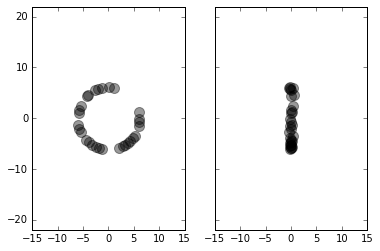

In [131]:
def apopto_pdf(zed, theta, z0=0.,
               width_apopto=0.3, amp=0.7):
    p = (np.exp(-(zed - z0)**2 / width_apopto**2) *
         (1 - amp*(np.cos(theta/2)**2)))
    return p

def get_apopto_cells(mono):

    np.random.seed(40)
    mono.face_df['theta'] = np.arctan2(mono.face_df['x'],
                                       mono.face_df['y'])
    
    p_apopto = apopto_pdf(mono.face_df.loc[mono.apical_faces, 'z'],
                          mono.face_df.loc[mono.apical_faces, 'theta'])
    rand_field = np.random.random(mono.face_df.loc[mono.apical_faces].shape[0])
    apopto_cells = p_apopto[p_apopto>rand_field].index
    apopto_cells = np.array([c for c in mono.face_df.loc[apopto_cells].sort_values('x').index
                             if mono.cell_df.loc[c, 'is_alive']])
    return apopto_cells

apopto_cells = get_apopto_cells(mono)
print('number of apoptotic cells: {}'.format(apopto_cells.size))

fig, (ax0, ax1) = plt.subplots(1, 2, sharex=True,
                               sharey=True)
ax0.scatter(mono.face_df.loc[apopto_cells, 'x'], 
            mono.face_df.loc[apopto_cells, 'y'], c='k',
            s=100, alpha=0.4)
ax0.set_aspect('equal')


ax1.scatter(mono.face_df.loc[apopto_cells, 'z'], 
            mono.face_df.loc[apopto_cells, 'y'], c='k',
            s=100, alpha=0.4)
ax1.set_aspect('equal')
ax1.set_xlim(-15, 15);

In [132]:
apopto_cells

array([ 470,  416, 1653, 1491, 1661,  389, 1629, 1271,  336,  551, 1378,
        281,  605, 1316, 1371,  254, 1607,  986,  200,  918,  713,  940,
        740, 1464, 1027,  767,   40, 1537,  848, 1274])

In [141]:
from tyssue.behaviors.monolayer_events import MonoLayerEvents
events = MonoLayerEvents(mono, BulkModel, MonoLayerGeometry)

for i in range(10):
    
    events.shrink(apopto_cells[0], 0.2)
    Solver.find_energy_min(mono, BulkGeometry, BulkModel)
    
    vispy_draw.vp_view(mono)

KeyboardInterrupt: 

> /home/guillaume/anaconda3/envs/py35/lib/python3.5/site-packages/numpy/core/fromnumeric.py(1091)resize()
   1089 
   1090 
-> 1091 def resize(a, new_shape):
   1092     """
   1093     Return a new array with the specified shape.

ipdb> c
